In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Librerie**

In [ ]:
#data from html page
import requests
from bs4 import BeautifulSoup
# Data manipulation
import numpy as np
import pandas as pd
import csv 
import re
import time
import gensim
from gensim.utils import simple_preprocess


# **Estrai link dal file del bot**

In [ ]:
link=[]
with open("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/productsBot.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    line=str(line)
    value= line.split('[')[1].split(']')[0]
    v=value.replace("'", "")
    link.append(v)   
#eliminiamo i duplicati   
mylist=np.unique(link).tolist()
with open("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/links.txt", "w") as f1:
    for lista in mylist:
      f1.write(lista)
      f1.write("\n")

# **Funzione per accedere al DOM**



In [ ]:
HEADERS = ({'User-Agent':
			'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
			AppleWebKit/537.36 (KHTML, like Gecko) \
			Chrome/90.0.4430.212 Safari/537.36',
			'Accept-Language': 'en-US, en;q=0.5'})

def getdata(url):
	r = requests.get(url, headers=HEADERS)
	return r


def html_code(url):
	htmldata = getdata(url)
	soup = BeautifulSoup(htmldata.content, 'html.parser')
	return (soup)

# **Lista top rewiewers amazon - NON AVVIARE**

In [ ]:
with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/top-reviewer.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Utente"])

for x in range (1,50000):
  url = "https://www.amazon.it/hz/leaderboard/top-reviewers/ref=cm_cr_tr_link_2?page="+str(x)
  soup = html_code(url)
  for item in soup.select('#pha-lb-page b'):
    with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/top-reviewer.csv', 'a', newline='') as file:
      print("x")
      writer = csv.writer(file)
      writer.writerow([item.text])

# **Recupero informazioni delle recensioni**



In [ ]:
def product_data(soup):
  
  name_product = []
  for item in soup.select("h1.a-size-large.a-text-ellipsis a.a-link-normal"):
    name_product.append(item["href"])  
  
  avarege = []
  for item in soup.select("div.AverageCustomerReviews span.a-color-base"):
    avarege.append(item.text)  

    
  pagine_review = []
  for r in soup.select('div.a-row a.a-size-base.a-link-normal.review-title.a-color-base.review-title-content.a-text-bold'):
    pagine_review.append("https://www.amazon.it"+r["href"])

  list_titolo_review = []
  list_data_review = []
  list_voti = []
  list_rate = []
  list_comment = []
  list_utenti = []  
  list_verificato = []
  for x in range (0,len(pagine_review)):
    soup = html_code(pagine_review[x])
    
    for r in soup.select('a.a-size-base span'):
      list_titolo_review.append(r.text)

    for r in soup.select('span.review-date'):
      list_data_review.append(r.text)

    for r in soup.select('span.cr-vote-text'):
        list_voti.append(r.text)
    if len(list_voti) == x:
        list_voti.append("0")
  
    for r in soup.select('span.a-icon-alt'):
      list_rate.append(r.text)
      break

    for r in soup.select('span.review-text span'):
      if r.text != " " and r.text != " Impossibile caricare il contenuto multimediale. ":
        list_comment.append(r.text)
    if len(list_comment) == x:
      list_comment.append("")

    for r in soup.select('a.a-profile'):
        list_utenti.append(r.text)

    for r in soup.select('span.a-profile-verified-badge'):
      list_verificato.append("Verificato")
    if len(list_verificato) == x:
        count = 0
        with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/top-reviewer.csv') as csv_file:
          csv_reader = csv.reader(csv_file, delimiter=',')
          for riga in csv_reader:
            count = count + 1
            if riga[0] == list_utenti[x]:
              list_verificato.append(count)
              break
    if len(list_verificato) == x:
      list_verificato.append("Oltre i 250000")
  
  #print(len(list_titolo_review))
  #print(len(list_data_review))
  #print(len(list_voti))
  #print(len(list_rate))
  #print(len(list_comment))
  #print(len(list_utenti))
  #print(len(list_verificato))

  with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/review.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    for x in range(0,len(list_utenti)):
      writer.writerow([list_utenti[x], list_verificato[x], name_product[0], list_titolo_review[x], list_comment[x], list_rate[x], avarege[0], list_data_review[x], list_voti[x]])
           

with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/review.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Utente", "Posizione_utente", "Prodotto", "Titolo", "Contenuto" ,"Rate", "Media", "Data", "Voti"])

file = open("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/links.txt", "r")
for line in file: 
  #Recuperiamo il numero di recensioni totali
  url = 'https://www.amazon.it/product-reviews' + line.split("/dp")[1]
  soup = html_code(url)
  number = 0
  data_str = ""
  span_content = []
  for item in soup.find_all("span", clas_=""):
    data_str = data_str + item.get_text()
    span_content.append(data_str)
    data_str = ""
  for x in range (0,len(span_content)):
    if "recensioni globali" in span_content[x]:
      n = span_content[x].split("| ")[1].split(" ")[0]
      n = n.replace('.', '')
      if int(n)%10 == 0:
        number = int(int(n)/10)
      else:
        number = int(int(n)/10) + 1
  #Recuperiamo le recensioni con la funzione cus_data
  for x in range (1,number+1):
    url = 'https://www.amazon.it/product-reviews' + line.split("/dp")[1] + '&pageNumber=' + str(x) 
    print(url)
    soup = html_code(url)
    product_data(soup)

In [ ]:
def product_data_oracolo():
  
  pagine_review = []
  file = open("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Oracolo.txt", "r")
  for line in file: 
    pagine_review.append(line)

  name_product = []
  avarege = []
  list_titolo_review = []
  list_data_review = []
  list_voti = []
  list_rate = []
  list_comment = []
  list_utenti = []  
  list_verificato = []
  for x in range (0,len(pagine_review)):
    soup = html_code(pagine_review[x])

    for item in soup.select("div.a-row.a-spacing-top-mini.a-text-ellipsis a.a-link-normal"):
      name_product.append(item["href"])  
  
    for item in soup.select("div.a-row span.a-size-medium.a-color-base"):
      avarege.append(item.text)  

    for r in soup.select('a.a-size-base span'):
      list_titolo_review.append(r.text)

    for r in soup.select('span.review-date'):
      list_data_review.append(r.text)

    for r in soup.select('span.cr-vote-text'):
        list_voti.append(r.text)
    if len(list_voti) == x:
        list_voti.append("0")
  
    for r in soup.select('span.a-icon-alt'):
      list_rate.append(r.text)
      break

    for r in soup.select('span.review-text span'):
      if r.text != " " and r.text != " Impossibile caricare il contenuto multimediale. ":
        list_comment.append(r.text)
    if len(list_comment) == x:
      list_comment.append("")
    print(pagine_review[x],list_comment[x])

    for r in soup.select('a.a-profile'):
        list_utenti.append(r.text)
    print(len(list_utenti))
    for r in soup.select('span.a-profile-verified-badge'):
      list_verificato.append("Verificato")
    if len(list_verificato) == x:
        count = 0
        with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/top-reviewer.csv') as csv_file:
          csv_reader = csv.reader(csv_file, delimiter=',')
          for riga in csv_reader:
            count = count + 1
            if riga[0] == list_utenti[x]:
              list_verificato.append(count)
              break
    if len(list_verificato) == x:
      list_verificato.append("Oltre i 250000")


  with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewOracolo.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    for x in range(0,len(list_utenti)):
      if x < 36:
        writer.writerow([list_utenti[x], list_verificato[x], name_product[x], list_titolo_review[x], list_comment[x], list_rate[x], avarege[x], list_data_review[x], list_voti[x],0])
      else:
        writer.writerow([list_utenti[x], list_verificato[x], name_product[x], list_titolo_review[x], list_comment[x], list_rate[x], avarege[x], list_data_review[x], list_voti[x],1])
      

with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewOracolo.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Utente", "Posizione_utente", "Prodotto", "Titolo", "Contenuto" ,"Rate", "Media", "Data", "Voti","Classe_Reale"])
product_data_oracolo()


#**Funzione per mettere se una recensione è fake o meno**

In [ ]:
def checkuser(posizione, review, star, media, data, voti):
  count=0
  numbers = re.findall('[0-9]+', data)
  numbers=int(numbers[1])
  if numbers<2020:
    return False
  #se la lunghezza della recensione è maggiore di 50 parole aumentiamo la probabilità 
  if len(review.split())>50:
    count+=1
  #se non è verificato aumentiamo la probabilità  
  if posizione!="Verificato" and posizione!="Oltre i 250000" and posizione<="50000":
      count+=1   
  #se ha 5 stelle aumentiamo la probabilità
  if star==5.0:
    count+=1
  #se il numero di stelle è minore di 3.5 e le stelle sono 5 
  if 3.5>media and star==5:
    count+=1 
  #se il numero di utili è maggiore di 2 aumentiamo la probabilità
  if voti<2:
    count+=1
  #se il conteggio finale è maggiore di 3, ovvero oltre la media, la recensione è finta  
  if count<4: return False
  else: return True

# **Data cleaning delle review**

In [ ]:
def clean_text(text):
  # togliamo questa stringa sottostante
    text= re.sub("Impossibile caricare il contenuto multimediale.", ' ',str(text)).strip()
    # togliamo le emoji
    text=text.encode('latin-1', 'ignore').decode('latin-1')
    # togliamo i caratteri new line 
    text= re.sub(r'\s+', ' ', text)
    #aggiustiamo la grammatica creando un dizionario e cambiando le parole
    correct_dict={"x":" per","nn":" non","ke":" che", "e'":"è","o'":"ò","a'":"à","u'":"ù"}
    #rimpiazziamo le parole
    for key,value in correct_dict.items():
        if key in text:
            text=text.replace(key,value)
    # togliamo due o più spazi
    text= re.sub(' +', ' ',text)
    # togliamo questa stringa sottostante
    text= re.sub("nan", ' ',text).strip()
    # convertiamo in minuscolo per mantenere la consistenza
    text= text.lower()
    return text

# convertiamo il testo in una lista di tokens.    
def simple_process(text):
    process_text = gensim.utils.simple_preprocess(text, deacc=True)
    text = ' '.join([word for word in process_text])
    return text

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/review.csv')
header = ["ID", "Utente", "Posizione_utente", "Prodotto", "Titolo", "Contenuto", "Rate", "Media", "Data", "Voti", "Classe"]
name=[]
position=[]
product=[]
title=[]
review=[]
rate=[]
media=[]
data=[]
voti=[]
with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewCleaned.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  count = 0
  #puliamo prima tutto il contenuto
  for table in df['Contenuto']:
    text = clean_text(table)
    if text != "" and len(text)!=0:
      review.append(text)

      #collezioniamo tutto
      name.append(df['Utente'][count]) 
      position.append(df['Posizione_utente'][count])
      product.append(df['Prodotto'][count])
      title.append(df['Titolo'][count]) 
      #le stelle e la media li facciamo diventare float e li inseriamo nel csv  
      value=float(re.sub(',', '.',df['Rate'][count][0:3]))  
      rate.append(value) 
      
      if("," in df['Media'][count][0:3]):
        value=float(re.sub(',', '.', df['Media'][count][0:3]))  
        media.append(value)
      else:
        media.append(float(df['Media'][count][0]))
      
      data.append(df['Data'][count])
      #convertiamo la stringa in un intero, altrimenti prendiamo il primo carattere, ovvero il numero di persone  
      if(df['Voti'][count] == "Una persona l'ha trovato utile"):
        voti.append(1)  
      else:
        #cerchiamo tutti i numeri, li convertiamo in interi e li inseriamo
        numbers = re.search('[0-9]+', df['Voti'][count])
        voti.append(int(numbers.group()))
      #print(review[count],name[count],position[count],media[count],product[count],title[count],rate[count],data[count],voti[count])  
    count = count + 1
  #inseriamo tutto nel csv, aggiungendo un id
  
  count = 0
  for i in range(len(name)):
    #checkuser ritorna se la recensione è fake o meno dando posizione, review, star, media, voti
    if checkuser(position[i], review[i], rate[i], media[i], data[i], voti[i]):
      full_review=i,name[i],position[i],product[i],title[i],review[i],rate[i],media[i],data[i],voti[i],1
      count = count + 1
      writer.writerow(full_review)
    else:
      full_review=i,name[i],position[i],product[i],title[i],review[i],rate[i],media[i],data[i],voti[i],0
      writer.writerow(full_review)
  print("fake: " + str(count))


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewOracolo.csv')
header = ["ID", "Utente", "Posizione_utente", "Prodotto", "Titolo", "Contenuto", "Rate", "Media", "Data", "Voti", "Classe_Reale", "Classe"]
name=[]
position=[]
product=[]
title=[]
review=[]
rate=[]
media=[]
data=[]
voti=[]
classe_reale =[]
with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewOracoloCleaned.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  count = 0
  #puliamo prima tutto il contenuto
  for table in df['Contenuto']:
    text = clean_text(table)
    if text != "" and len(text)!=0:
      review.append(text)

      #collezioniamo tutto
      name.append(df['Utente'][count]) 
      position.append(df['Posizione_utente'][count])
      product.append(df['Prodotto'][count])
      title.append(df['Titolo'][count]) 
      #le stelle e la media li facciamo diventare float e li inseriamo nel csv  
      value=float(re.sub(',', '.',df['Rate'][count][0:3]))  
      rate.append(value) 
      
      if("," in df['Media'][count][0:3]):
        value=float(re.sub(',', '.', df['Media'][count][0:3]))  
        media.append(value)
      else:
        media.append(float(df['Media'][count][0]))
      
      data.append(df['Data'][count])
      #convertiamo la stringa in un intero, altrimenti prendiamo il primo carattere, ovvero il numero di persone  
      if(df['Voti'][count] == "Una persona l'ha trovato utile"):
        voti.append(1)  
      else:
        #cerchiamo tutti i numeri, li convertiamo in interi e li inseriamo
        numbers = re.search('[0-9]+', df['Voti'][count])
        voti.append(int(numbers.group()))

      classe_reale.append(df['Classe_Reale'][count])
      
      count = count + 1
  #inseriamo tutto nel csv, aggiungendo un id
  count = 0
  count2 = 0
  for i in range(len(name)):
    #checkuser ritorna se la recensione è fake o meno dando posizione, review, star, media, voti
    if checkuser(position[i], review[i], rate[i], media[i], data[i], voti[i]):
      full_review=i,name[i],position[i],product[i],title[i],review[i],rate[i],media[i],data[i],voti[i], classe_reale[i], 1
      count = count + 1
      writer.writerow(full_review)
    else:
      full_review=i,name[i],position[i],product[i],title[i],review[i],rate[i],media[i],data[i],voti[i],classe_reale[i], 0
      count2 = count2 + 1
      writer.writerow(full_review)
  print("fake: " + str(count))
  print("not fake: " + str(count2))

fake: 4
not fake: 58


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewOracoloCleaned.csv')
header = ["Commento", "Classe"]

with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Test.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  for i in range(len(df)):
    test=df['Contenuto'][i],df['Classe_Reale'][i]
    writer.writerow(test)

# **Prende da una lista di link il nome del venditore e le informazioni**

In [ ]:
def seller_date(site,product):  
  #colonne per il csv venditore
  header = ['Prodotto','Venditore','NomeAzienda','Tipo di attivita','Numero di iscrizione al registro delle imprese','Numero di partita IVA','Numero di telefono','Indirizzo Servizio clienti','Indirizzo aziendale']

  with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/AmazonDatasetSeller.csv', 'a') as f:
    writer = csv.writer(f)
    seller = site.find(id='sellerName')
    
    azienda = site.find('ul', class_="a-unordered-list a-nostyle a-vertical")
    #regex per eliminare tutto prima dei ":"
    rx_to_last = r'^.*{}'.format(re.escape(":"))
    #array che contiene tutti i dati
    col=[]
    col.append(product)
    if(seller is not None):
      col.append(seller.get_text())
    else: return None
    #count per aggiungere i valori nulli dalla quinta colonna
    count=0
    #controllo dei parametri e inserimento del valore nullo in caso di valore mancante, forse l'ultimo non serve perchè deve essere obbligatorio per legge
    for a in azienda:
      if count==0 and not re.search(r"Nome azienda:", a.get_text()):
        col.append("None")
        count+=1
      elif count==0 and re.search(r"Nome azienda:", a.get_text()):
        myString=re.sub(r"Nome azienda:","", a.get_text()).strip()  
        if not myString:
          col.append("None")
          count+=1 
      if count==1 and not re.search(r"Tipo di attività:", a.get_text()):
        col.append("None")
        count+=1
      elif count==1 and re.search(r"Tipo di attività:", a.get_text()):
        myString=re.sub(r"Tipo di attività:","", a.get_text()).strip()   
        if not myString:
          col.append("None")
          count+=1 
      if count==2 and not re.search(r"Numero di iscrizione al registro delle imprese:", a.get_text()):
        col.append("None")
        count+=1
      elif count==2 and re.search(r"Numero di iscrizione al registro delle imprese:", a.get_text()):
        myString=re.sub(r"Numero di iscrizione al registro delle imprese:","", a.get_text()).strip()   
        if not myString:
          col.append("None")
          count+=1 
      if count==3 and not re.search(r"Numero di partita IVA:", a.get_text()):
        col.append("None")
        count+=1
      elif count==3 and re.search(r"Numero di partita IVA:", a.get_text()):
        myString=re.sub(r"Numero di partita IVA:","", a.get_text()).strip()   
        if not myString:
          col.append("None")
          count+=1 
      if count==4 and not re.search(r"Numero di telefono:", a.get_text()):
        col.append("None")
        count+=1
      elif count==4 and re.search(r"Numero di telefono:", a.get_text()):
        myString=re.sub(r"Numero di telefono:","", a.get_text()).strip()   
        if not myString:
          col.append("None")
          count+=1 
      if count==5 and not re.search(r"Indirizzo Servizio clienti:", a.get_text()):
        col.append("None")
        count+=1
      elif count==5 and re.search(r"Indirizzo Servizio clienti:", a.get_text()):
        myString=re.sub(r"Indirizzo Servizio clienti:","", a.get_text()).strip()   
        if not myString:
          col.append("None")
          count+=1   
      if count==6 and not re.search(r"Indirizzo aziendale:", a.get_text()):
        col.append("None")
        count+=1
      elif count==6 and re.search(r"Indirizzo aziendale:", a.get_text()):
        myString=re.sub(r"Indirizzo aziendale:","", a.get_text()).strip()   
        if not myString:
          col.append("None")
          count+=1   
      if count>=7: break
      count+=1
      col.append(re.sub(rx_to_last, '', a.get_text(), flags=re.DOTALL).strip())
    #se non ci sono tutti gli attributi, riempi l'array
    if len(col)<9:
      for i in range(0,9-len(col)):
        col.append("None")
    #dopo aver inserito tutti i parametri in col, inserisce tutta la tupla nel csv 
    writer.writerow(col)

with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/AmazonDatasetSeller.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Prodotto','Venditore','NomeAzienda','TipoDiAttivita','NumeroDiIscrizioneAlRegistroDelleImprese','NumeroDiPartitaIVA','NumeroDiTelefono','IndirizzoServizioClienti','IndirizzoAziendale'])

file = open("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/links.txt", "r")

for line in file:
    #vai alla pagina 
    site = html_code(line)
    #prendi il titolo del prodotto e il venditore e inserisci nei relativi array
    azienda = site.find(id="sellerProfileTriggerId")
    
    if(azienda is not None):
      prodotto = site.find(id="productTitle").get_text()
      webpage="https://www.amazon.it"+ azienda["href"]
      site = html_code(webpage)
      seller_date(site,prodotto)

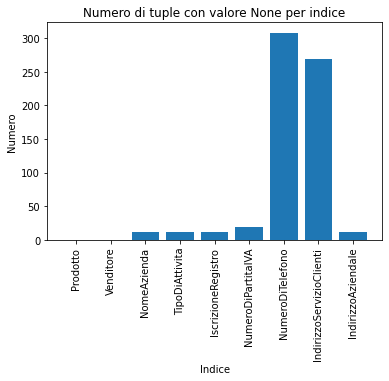

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

indice = [0,0,0,0,0,0,0,0,0]
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/AmazonDatasetSeller.csv")

for x in range(0,len(df)):
  if df["Prodotto"][x] == "None": indice[0] = indice[0] + 1 
  if df["Venditore"][x] == "None": indice[1] = indice[1] + 1 
  if df["NomeAzienda"][x] == "None": indice[2] = indice[2] + 1
  if df['TipoDiAttivita'][x] == "None": indice[3] = indice[3] + 1 
  if df['NumeroDiIscrizioneAlRegistroDelleImprese'][x] == "None": indice[4] = indice[4] + 1 
  if df['NumeroDiPartitaIVA'][x] == "None": indice[5] = indice[5] + 1 
  if df['NumeroDiTelefono'][x] == "None": indice[6] = indice[6] + 1 
  if df['IndirizzoServizioClienti'][x] == "None": indice[7] = indice[7] + 1 
  if df['IndirizzoAziendale'][x] == "None": indice[8] = indice[8] + 1  

labels = ['Prodotto','Venditore','NomeAzienda','TipoDiAttivita','IscrizioneRegistro','NumeroDiPartitaIVA','NumeroDiTelefono','IndirizzoServizioClienti','IndirizzoAziendale']

x_pos = np.arange(len(labels))

plt.bar(x_pos, indice, align='center')
plt.xticks(x_pos, labels,rotation = "vertical")
plt.ylabel('Numero')
plt.xlabel('Indice')
plt.title('Numero di tuple con valore None per indice')
plt.savefig('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/dataSeller.png',bbox_inches = "tight")
plt.show()

# **Zero-shot**

In [ ]:
def Estrattore_parole():
  list_comment = []
  file = open("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewfake.txt")
  for line in file:
    soup = html_code(line)
    for r in soup.select('span.review-text span'):
      if r.text != " " and r.text != " Impossibile caricare il contenuto multimediale. ":
        list_comment.append(r.text)
    
  map = {}
  for x in range(0,len(list_comment)):
      parts = list_comment[x].split(" ")
      for i in range(0,len(parts)):
        try: 
          map[parts[i]]
          map[parts[i]]["Numero"] = map[parts[i]]["Numero"] + 1 
        except:
          map[parts[i]] = {}
          map[parts[i]]["Numero"] = 1 

  word = []
  for x in map:
    if map[x]["Numero"] > 3 and len(x) > 3:
      word.append(x)
  return word
 
dataset = pd.read_csv('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewCleaned.csv')
word = Estrattore_parole()
print(word)
classifier = pipeline('zero-shot-classification')

with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Zero_shot_result.csv', 'w') as f:
    writer = csv.writer(f)
    column_name = ["Commento"] 
    for x in range(0,len(word)):
      column_name.append(word[x])
    writer.writerow(column_name)
    
    for x in range(0,len(dataset)):
      print(x)
      if dataset['Classe'][x] == 1:
        zero_shot_result = classifier(dataset['Contenuto'][x],word)
        zero_shot_result_word_order = [dataset['Contenuto'][x]]
        for y in range(0,len(word)):
          for m in range(0,len(zero_shot_result['labels'])):
            if zero_shot_result['labels'][m] == word[y]:
              zero_shot_result_word_order.append(zero_shot_result['scores'][m])
        writer.writerow(zero_shot_result_word_order)
        